In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
direc = Path("samples")
dir_img = sorted(list(map(str, list(direc.glob("*.png")))))
img_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in dir_img]

char_img = set(char for label in img_labels for char in label)
char_img = sorted(list(char_img))

print("Number of dir_img found: ", len(dir_img))
print("Number of img_labels found: ", len(img_labels))
print("Number of unique char_img found: ", len(char_img))
print("Characters present: ", char_img)

#Batch size of training and validation
batch_size = 16

# Setting dimensions of the image
img_width = 200
img_height = 50

# Setting downsampling factor
downsample_factor = 4

# Setting the Maximum Length
max_length = max([len(label) for label in img_labels])

# Char to integers
char_to_num = layers.StringLookup(
    vocabulary = list(char_img), mask_token = None
)

# Integers to original chaecters
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True
)

def data_split(dir_img, img_labels, train_size = 0.9, shuffle = True):
    # Get the total size of the dataset
    size = len(dir_img)
    # Create an indices array and shuffle it if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    # Calculate the size of training samples
    train_samples = int(size * train_size)
    
    # Split data into training and validation sets
    x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]]

    x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]]

    return x_train, x_valid, y_train, y_valid

# Split data into training and validation sets
x_train, x_valid, y_train, y_valid = data_split(np.array(dir_img), np.array(img_labels))

def encode_sample(img_path, label):
    # Read the image
    img = tf.io.read_file(img_path)

    # Converting the image to grayscale
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resizing to the desired size
    img = tf.image.resize(img, [img_height, img_width])

    # Transposing the image
    img = tf.transpose(img, perm = [1, 0, 2])

    # Mapping image label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding = "UTF-8"))

    return {"image":img, "label":label}
    

Number of dir_img found:  1040
Number of img_labels found:  1040
Number of unique char_img found:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [12]:
# Creating training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train =(
    dataset_train.map(
        encode_sample, num_parallel_calls = tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

# Creating validation dataset
val_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_data =(
    val_data.map(
        encode_sample, num_parallel_calls = tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

2025-11-07 20:26:56.101222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


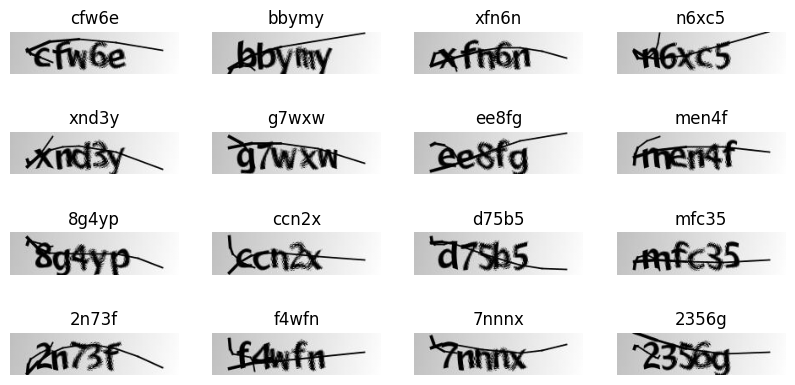

In [13]:
# Visualizing some training data
_, ax = plt.subplots(4, 4, figsize = (10, 5))
for batch in dataset_train.take(1):
    dir_img = batch["image"]
    img_labels = batch["label"]
    for i in range(16):
        img = (dir_img[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(
            img_labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap = "gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()
